<a href="https://colab.research.google.com/github/nlp-en-es/nlp-de-cero-a-cien/blob/main/6_transformers_4/fine_tune_Spanish_GPT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenar (fine-tuning) Spanish GPT-2 para generación de letras de RAP
### Adaptación del [Colab](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/language_modeling_from_scratch.ipynb) de Sylvain Gugger

- **CLM**: el modelo tiene que predecir el siguiente token en la oración (por lo que las etiquetas son las mismas que las entradas desplazadas hacia la derecha). Para asegurarse de que el modelo no haga trampa, obtiene una máscara de atención que le impedirá acceder a los tokens después del token i cuando intente predecir el token i + 1 en la oración.

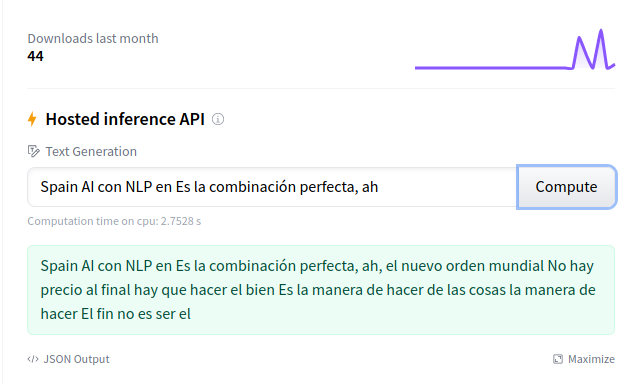

[Probar el modelo](https://huggingface.co/Narrativa/spanish-gpt2-finetuned-rap-lyrics?text=Spain+AI+con+NLP+en+Es+la+combinaci%C3%B3n+perfecta%2C+ah)

### Comprobamos la GPU asignada

In [ ]:
! nvidia-smi

Tue Sep 21 09:39:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Autenticación en HF (para compartir modelo)

Para poder compartir nuestro modelo con la comunidad y generar resultados como el que se muestra en la imagen de arriba a través de la API de inferencia, hay algunos pasos más a seguir.

Primero debe almacenar su token de autenticación del sitio web HuggingFace (regístrate [aquí] (https://huggingface.co/join) si aún no lo ha hecho), luego ejecute la siguiente celda e ingrese su nombre de usuario y contraseña:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


Luego, debemos instalar `Git-LFS` y configurar Git si aún no lo hemos hecho. Descomenta las siguientes instrucciones e introduzca su nombre y correo electrónico:

In [ ]:
# !apt install git-lfs
# !git config --global user.email "you@example.com"
# !git config --global user.name "Your Name"

### Instalamos las dependencias requeridas

In [ ]:
! pip install -q transformers datasets

### Elegimos un modelo (checkpoint)

In [ ]:
model_checkpoint = "datificate/gpt2-small-spanish"

### Elegimos y pre-procesamos el dataset

- Dataset: [Letras de canciones de rap en español](https://www.kaggle.com/smunoz3801/9325-letras-de-rap-en-espaol) (Kaggle)

In [ ]:
'''
%%bash
# Descarga desde Kaggle
# Subir archivo `kaggle.json`
pip install -q kaggle
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download -d smunoz3801/9325-letras-de-rap-en-espaol
'''

In [ ]:
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-3xPU8ZofDuyHrsgQvNgUikQXLazocYl' -O rap_corpus.csv

--2021-09-21 09:39:16--  https://docs.google.com/uc?export=download&id=1-3xPU8ZofDuyHrsgQvNgUikQXLazocYl
Resolving docs.google.com (docs.google.com)... 74.125.142.138, 74.125.142.139, 74.125.142.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-8o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ur4s0tqfi0sdg28prtbfjba4cv7dmof5/1632217125000/00064677491372109560/*/1-3xPU8ZofDuyHrsgQvNgUikQXLazocYl?e=download [following]
--2021-09-21 09:39:17--  https://doc-08-8o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ur4s0tqfi0sdg28prtbfjba4cv7dmof5/1632217125000/00064677491372109560/*/1-3xPU8ZofDuyHrsgQvNgUikQXLazocYl?e=download
Resolving doc-08-8o-docs.googleusercontent.com (doc-08-8o-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-08-8o-docs.googleusercontent.com (doc-08-8o-do

In [ ]:
from datasets import load_dataset
dataset = load_dataset('csv', data_files=['/content/rap_corpus.csv'], split='train')
datasets = dataset.train_test_split(test_size=0.10)

Using custom data configuration default-466fd0d2524b006d


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-466fd0d2524b006d/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'artista', 'cancion', 'album', 'letra', 'anyo', 'visitas'],
        num_rows: 8392
    })
    test: Dataset({
        features: ['id', 'artista', 'cancion', 'album', 'letra', 'anyo', 'visitas'],
        num_rows: 933
    })
})

In [ ]:
datasets["train"][10]

{'album': 'Mindfuck',
 'anyo': 2015,
 'artista': 'Mediyama',
 'cancion': 'La habitación del pánico',
 'id': 24,
 'letra': "La mente en blanco, el tiempo me huele a plástico,\nmaquillando el karma con papel pintado.\nDejando libres las miserias en casa, más luego fuera,\nparecen fieras, y no lo son tanto...\nBuscando iguales para males afines, días de cine,\nnoches en vela, peña dormida en cojines.\nSexo por hobbie con la cara de un lunes.\nY una sospecha, disfrútalo mientras te dure.\nPerder el juicio como el crédito, vivir corriendo.\nVida rápida ostia fijo, lo demás son cuentos.\nHijos del caos en aumento, usando tu cerebro por ti,\n¿por cuánto tiempo?\nSon hormigas y obejas, fauna que asiente.\nDe fábula, de tipos como Drácula, sin dientes.\nNo quedan dioses que no quieran, nos queda el TDT,\npodemos ver, olemos muerte.\nGastando suela en aceras, gastando acero.\nRompiéndome los puños contra un saco del que cae dinero,\ncomo un motor de dos tiempos, acelerao',\ncomo un loco corriend

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=3):
    assert num_examples <= len(dataset), "El número de filas a mostrar no puede ser mayor que el número de filas en el dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(datasets["train"])

,id,artista,cancion,album,letra,anyo,visitas
0,12,Dano y Skyhook,Bellagio,Braille,"[Estribillo] (x2)\n¿Dices que darías tu vida?\nQuieres estar en La Liga,\nIr en bus con la Copa,\nSaludar desde arriba,\nNo hagas el Sergio Ramos primo,\nQue alguien te mira,\nHacer bien de platica,\nDiamante de Zanzíbar,\nSuelos de mármol,\nMorir en la piscina,\nRecubierto de harina.\n\n\nSoy el viento tras la pared,\nUn pensamiento invade tu sien,\nEntre arbustos alguien nos ve,\nTú pilla el fusco, acaba con él,\nPrepara el cóctel, Molotov es,\nLebara, el móvil, no lo apuntes,\nSi oyes pasos en el jardín,\nProtege tu cuello como Wu-Tang,\nVivo en estrés, \nJunior Mafia, Chico del Vec,\nDime cómo llego a final de mes,\nSin delinquir, sin libanés,\nLe hice un pedido, al fin asintió,\nVive con miedo a la ira de Dios,\nLe dio a su piba un bolsito de Dior,\nDesesperado, Kira Miró,\nVive sin mirar el precio,\nCon la sonrisa de Lecquio,\nTodo su día es comercio,\nIdas de olla, cuida ese nervio,\n¿Cómo conviertes el amor, en el dedo corazón?\nQuise cazarte como un pokémon y no me salió ¡Shit!\nTuve un reino casi a mis pies,\nComo siempre, fui y la cagué,\nMe rodeo de pibes perdidos con ese look de niño Francés,\nNo hay secretos en el clan,\nBuscábamos reventar,\nMorir joven y dejar un buen cuerpo,\nTutankhamon de verdad ¡Shit!\n\n\n[Estribillo] (x2)\n¿Dices que darías tu vida?\nQuieres estar en La Liga,\nIr en bus con la Copa,\nSaludar desde arriba,\nNo hagas el Sergio Ramos primo, \nQue alguien te mira,\nHacer bien de platica,\nDiamante de Zanzíbar,\nSuelos de mármol,\nMorir en la piscina,\nRecubierto de harina.",2017,1209
1,21,aiSHO y Pino,Dame1minuto,Dame1minuto Vol. 3,"Mi madre me dice que yo soy un desastre,\nUn pura sangre, yo soy el Pino un punto y aparte,\nY que rapeando yo soy un salvaje,\nY mis frases, forman parte de las bases,\nY que mi corazón parece un desguace,\nUn desfase, el MC de las ciudades soy,\nY todos saben que no puedo amarte,\nYa que yo soy el monumento de todas las partes soy,\nEllos saben que lo soy,\nPero que miedo dan con esas pintas de locas del pop,\nTodos morirán nena! te lo digo yo,\nEl Pino, yo soy el que fabrica a los b.boys,\nTu sigue bailando por favor,\nAhora comentan que son ellos y te digo que no,\nPor eso no callo, oye payo, aquí yo soy un dios,\nNo temo a nada ni nadie porque es mi puto don.\nDéjame tranquilo por favor,\nDéjame tranquilo por favor,\nDéjame tranquilo por favor,\nSolo te pido un minuto que sin ti estoy mejor.\nDéjame tranquilo por favor,\nDéjame tranquilo por favor,\nDéjame tranquilo por favor,\nSolo te pido un minuto con mi hermano y productor.",2019,668
2,34,Soriano,Nada que temer (con Nano MC y Koala),Sin motivo aparente,"[Nano Mc]\nAntes de ponerme a hablar de nada quiero darte un consejo,\nno soy el mismo de antes, sólo ves un reflejo pues,\nhoy brillo más que ayer y camino con los ojos cerraos\npero sin nada que temer no.\nSería un falso conmigo mismo,\nsoy realista especialista, no perder el optimismo,\ny es que los malos sueños me han hecho seguir,\ndando pasos de ciego pero nunca desistir.\nReconocer que siento miedo\nal día que falte la persona que me saque de este enredo.\nPorque me quema la soledad,\nporque me queman las mentiras cuando busco la verdad y\nle temo al odio y la sin razón,\nle temo al día que deje de escribir con el corazón,\nle temo a cada decisión mala,\nle temo a no vivir libre y dejar de ser un bala.\n\n\n[Soriano]\nSiento miedo de no poder salir de este agujero,\nsi los hombres no lloran yo debo ser un bicho raro pero,\nescuchando la base me siento al pelo,\nme transmite gran tranquilidad el saber que no estoy solo.\nMiedo, a que se me olviden los recuerdos\nMiedo, a que se me enfríe la mirada\nMiedo de mi mismo porque a veces me pierdo\nMiedo a no tener miedo de nada\nSientes como se te clavan las lanzas,\ny el tiempo va más rápido que tu y no lo alcanzas,\nalza la mano y no pierdas la esperanza,\nhace falta un poco más de peso en la balanza\nda igual cuántas vece

### Tokenización del dataset

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Downloading:   0%|          | 0.00/620 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/817 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/387 [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(examples):
    return tokenizer(examples["letra"])

In [ ]:
tokenized_datasets = datasets.map(tokenize_fn, batched=True, remove_columns=["id", "artista", "album", "cancion", "anyo", "visitas", "letra"])

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets.column_names

{'test': ['attention_mask', 'input_ids'],
 'train': ['attention_mask', 'input_ids']}

In [ ]:
tokenized_datasets["train"][1]

{'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  

In [ ]:
len(tokenized_datasets["train"][5]['input_ids'])

511

### Formatear el dataset

Ahora, para la parte más difícil: necesitamos concatenar todos nuestros textos juntos y luego dividir el resultado en pequeños trozos de un cierto `block_size`. Para hacer esto, usaremos el método `map` nuevamente, con la opción` batched = True`. Esta opción en realidad nos permite cambiar la cantidad de ejemplos en los conjuntos de datos al devolver una cantidad diferente de ejemplos a la que obtuvimos. De esta manera, podemos crear nuestras nuevas muestras a partir de un lote de ejemplos.

Primero, tomamos la longitud máxima con la que se entrenó previamente nuestro modelo. Esto podría ser demasiado grande para caber en la RAM de nuestra GPU, por lo que aquí tomamos un poco menos de solo 128.

In [ ]:
#block_size = tokenizer.model_max_length
block_size = 128

In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Primero tenga en cuenta que duplicamos las entradas para nuestras etiquetas. Esto se debe a que el modelo de la biblioteca 🤗 Transformers aplica el desplazamiento a la derecha, por lo que no es necesario que lo hagamos manualmente.

También tenga en cuenta que, por defecto, el método `map` enviará un lote de 1000 ejemplos para ser tratados por la función de preprocesamiento. Entonces, aquí, soltaremos el resto para hacer que los textos tokenizados concatenados sean un múltiplo de `block_size` cada 1,000 ejemplos. Puede ajustar este comportamiento pasando un tamaño de lote mayor (que también se procesará más lentamente).

### Entrenar el modelo

In [ ]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/510M [00:00<?, ?B/s]

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    "rap-clm",
    #per_device_train_batch_size = 2,
    #per_device_eval_batch_size = 2,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    #push_to_hub=True,
    #push_to_hub_model_id=f"{model_name}-finetuned-rap",
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
)

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 5444
  Batch size = 8


{'eval_loss': 4.9603095054626465,
 'eval_runtime': 59.6434,
 'eval_samples_per_second': 91.276,
 'eval_steps_per_second': 11.418}

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 48859
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18324


Epoch,Training Loss,Validation Loss
1,4.182800,4.080521
2,4.067900,4.009733
3,4.030400,3.987478


Saving model checkpoint to rap-clm/checkpoint-500
Configuration saved in rap-clm/checkpoint-500/config.json
Model weights saved in rap-clm/checkpoint-500/pytorch_model.bin
Saving model checkpoint to rap-clm/checkpoint-1000
Configuration saved in rap-clm/checkpoint-1000/config.json
Model weights saved in rap-clm/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to rap-clm/checkpoint-1500
Configuration saved in rap-clm/checkpoint-1500/config.json
Model weights saved in rap-clm/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to rap-clm/checkpoint-2000
Configuration saved in rap-clm/checkpoint-2000/config.json
Model weights saved in rap-clm/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to rap-clm/checkpoint-2500
Configuration saved in rap-clm/checkpoint-2500/config.json
Model weights saved in rap-clm/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to rap-clm/checkpoint-3000
Configuration saved in rap-clm/checkpoint-3000/config.json
Model weights save

Saving model checkpoint to rap-clm/checkpoint-6500
Configuration saved in rap-clm/checkpoint-6500/config.json
Model weights saved in rap-clm/checkpoint-6500/pytorch_model.bin
Saving model checkpoint to rap-clm/checkpoint-7000
Configuration saved in rap-clm/checkpoint-7000/config.json
Model weights saved in rap-clm/checkpoint-7000/pytorch_model.bin
Saving model checkpoint to rap-clm/checkpoint-7500
Configuration saved in rap-clm/checkpoint-7500/config.json
Model weights saved in rap-clm/checkpoint-7500/pytorch_model.bin
Saving model checkpoint to rap-clm/checkpoint-8000
Configuration saved in rap-clm/checkpoint-8000/config.json
Model weights saved in rap-clm/checkpoint-8000/pytorch_model.bin
Saving model checkpoint to rap-clm/checkpoint-8500
Configuration saved in rap-clm/checkpoint-8500/config.json
Model weights saved in rap-clm/checkpoint-8500/pytorch_model.bin
Saving model checkpoint to rap-clm/checkpoint-9000
Configuration saved in rap-clm/checkpoint-9000/config.json
Model weights s

TrainOutput(global_step=18324, training_loss=4.153958137210762, metrics={'train_runtime': 6912.8486, 'train_samples_per_second': 21.204, 'train_steps_per_second': 2.651, 'total_flos': 9574850543616000.0, 'train_loss': 4.153958137210762, 'epoch': 3.0})

In [ ]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 5444
  Batch size = 8


Perplexity: 53.92
